### Convert SDO/AIA data from level 1 to level 1.5

AIA data products provides by the JSOC are level 1 data products.  
This means that the images still include the roll angle of the satellite and each channel may have a slightly different pixel scale.  
Typically, before performing any sort of data analysis on AIA images, you will want to promote your AIA data from level 1 to level 1.5.

1. Pointing correction (aiapy.calibrate.update_pointing)  
2. Image respiking (aiapy.calibrate.respike)  
3. PSF deconvolution (aiapy.psf.deconvolve)  
4. Registration (aiapy.calibrate.register)  
5. Degradation correction (aiapy.calibrate.correct_degradation)  
6. Exposure normalization

In this code, we only use method 1, 4, 5, and 6.

Reference.
https://aiapy.readthedocs.io/en/stable/preparing_data.html

In [1]:
import copy
import warnings

import numpy as np

import astropy.units as u

import sunpy
from sunpy.map import contains_full_disk

import aiapy
from aiapy.calibrate.util import get_pointing_table
from aiapy.calibrate.util import get_correction_table
from aiapy.util.exceptions import AIApyUserWarning

__all__ = ["update_pointing"]

In [2]:
fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2012\aia.lev1_euv_12s.2012-01-01T000009Z.193.image_lev1.fits"
aia_map = sunpy.map.Map(fits_file)
type(aia_map)

sunpy.map.sources.sdo.AIAMap

#### 1. Pointing correction

aiapy.calibrate.update_pointing(smap, *, pointing_table)

pointing_table = ``get_pointing_table``  
: This method removes any ``PCi_j`` matrix keys in the header and updates the ``CROTA2`` keyword.

In [3]:
pointing_tbl = get_pointing_table(
    "JSOC",
    time_range=(aia_map.date - 6*u.hour, aia_map.date + 6*u.hour)
)

aia_map_pt = aiapy.calibrate.update_pointing(aia_map, pointing_table=pointing_tbl)

In [4]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2","CROTA2"]:
    print(key, "before:", aia_map.meta[key], "after:", aia_map_pt.meta[key])


CRPIX1 before: 2043.09998 after: 2043.348511
CRPIX2 before: 2042.29004 after: 2041.547485
CDELT1 before: 0.600758016 after: 0.600714
CDELT2 before: 0.600758016 after: 0.600714
CROTA2 before: 0.0564525016 after: 0.0578085015073


#### 2. Registration

In [5]:
aia_map_reg = aiapy.calibrate.register(
    aia_map_pt,
    missing=np.nan,     # extrapolation: fill with NaN
    order=3,            # interpolation: bicubic        
    method='scipy'      # Rotation function to use: scipy
)

In [6]:
# To check a change.
for key in ["CRPIX1","CRPIX2","CDELT1","CDELT2"]:
    print(key, "before:", aia_map_pt.meta[key], "after:", aia_map_reg.meta[key])

CRPIX1 before: 2043.348511 after: 2048.5
CRPIX2 before: 2041.547485 after: 2048.5
CDELT1 before: 0.600714 after: 0.6
CDELT2 before: 0.600714 after: 0.6


#### 3. Degradation correction

In [7]:
corr_tbl = get_correction_table("SSW")

aia_map_cal = aiapy.calibrate.correct_degradation(
    aia_map_reg,
    correction_table=corr_tbl
)

In [8]:
print("before:", aia_map_reg.date.isot, " after:", aia_map_cal.date.isot)

before: 2012-01-01T00:00:07.838  after: 2012-01-01T00:00:07.838


#### 4. Exposure normalization

In [9]:
exp_time = aia_map_cal.exposure_time

aia_map_norm = aia_map_cal / exp_time

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2012-07-30 12:00:06
Exposure Time,1.9995419999999997 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.6 0.6] arcsec / pix
Reference Pixel,[2047.5 2047.5] pix

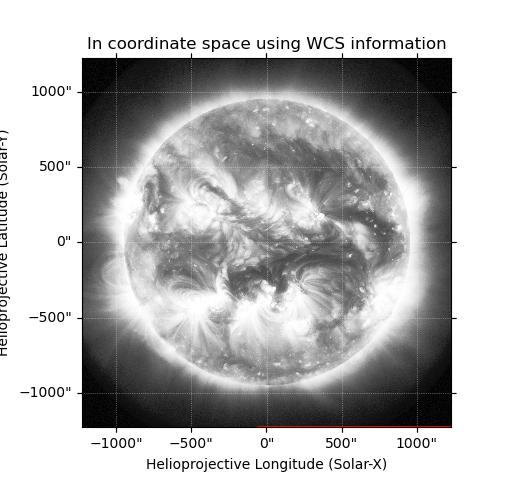
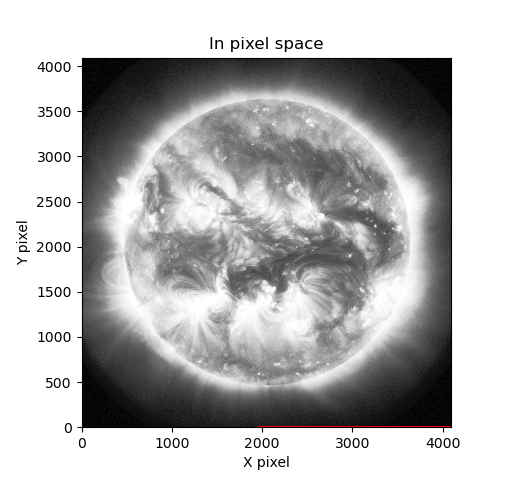
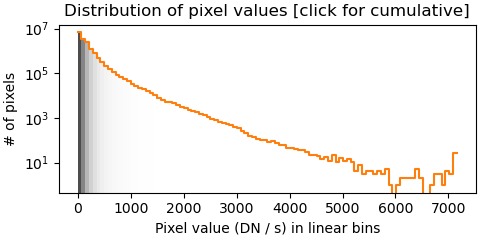
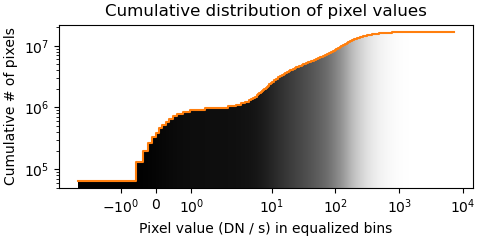

In [12]:
import sunpy
from convert_to_level1_5 import convert_to_level1_5 as conv_lev1_5

fits_file = r"E:\Research\SR\input\CH_Indices\EUV_level1\193\2012\aia.lev1_euv_12s.2012-07-30T120008Z.193.image_lev1.fits"
aia_map = sunpy.map.Map(fits_file)
conv_lev1_5(aia_map)

In [20]:
import numpy as np
import astropy.units as u
import aiapy
from aiapy.calibrate.util import get_pointing_table
from aiapy.calibrate.util import get_correction_table

from functools import lru_cache
from sunpy.time import parse_time
def safe_get_pointing(date_day: str):
    for src in ("JSOC", "SSW"):
        try:
            return get_pointing_table(src,
                     time_range=(parse_time(date_day) - 12*u.hour,
                                 parse_time(date_day) + 12*u.hour))
        except Exception:
            continue   # 다음 소스로 폴백
    raise RuntimeError("Both JSOC and SSW queries failed.")

@lru_cache(maxsize=1024)
def _cached_pointing(date_day: str):
    return safe_get_pointing(date_day)

# download correction table only once
try:
    CORR_TBL = get_correction_table("JSOC")
except Exception:
    CORR_TBL = get_correction_table("SSW")


"Pointing correction"
def Pointing_correction(aia_map):
    pointing_tbl = safe_get_pointing(aia_map.date.isot[:10])  # YYYY-MM-DD
    aia_map_pt = aiapy.calibrate.update_pointing(
        aia_map, pointing_table=pointing_tbl
    )
    return aia_map_pt

In [21]:
safe_get_pointing(aia_map.date.isot[:10])

ORIGIN,TELESCOP,DATE,T_START,T_STOP,T_HKVALS,VERSION,SC_Y_INRT_BIAS,SC_Z_INRT_BIAS,H_CAM1_IMSCALE,H_CAM1_X0,H_CAM1_Y0,H_CAM1_INSTROT,H_CAM2_IMSCALE,H_CAM2_X0,H_CAM2_Y0,H_CAM2_INSTROT,A_094_IMSCALE,A_094_X0,A_094_Y0,A_094_INSTROT,A_131_IMSCALE,A_131_X0,A_131_Y0,A_131_INSTROT,A_171_IMSCALE,A_171_X0,A_171_Y0,A_171_INSTROT,A_193_IMSCALE,A_193_X0,A_193_Y0,A_193_INSTROT,A_211_IMSCALE,A_211_X0,A_211_Y0,A_211_INSTROT,A_304_IMSCALE,A_304_X0,A_304_Y0,A_304_INSTROT,A_335_IMSCALE,A_335_X0,A_335_Y0,A_335_INSTROT,A_1600_IMSCALE,A_1600_X0,A_1600_Y0,A_1600_INSTROT,A_1700_IMSCALE,A_1700_X0,A_1700_Y0,A_1700_INSTROT,A_4500_IMSCALE,A_4500_X0,A_4500_Y0,A_4500_INSTROT,HMI_FSW_AL1_POSITION,HAL1POS,HMI_FSW_AL2_POSITION,HAL2POS,HMI_AL1_STATUS,HAL1STAT,HMI_AL2_STATUS,HAL2STAT,HMI_ISS_ERRGAINY,HIERRGNY,HMI_ISS_ERRGAINZ,HIERRGNZ,HMI_ISS_ERROFFY,HIERROFY,HMI_ISS_ERROFFZ,HIERROFZ,HMI_ISS_PZTOFFA,HIPZTOFA,HMI_ISS_PZTOFFB,HIPZTOFB,HMI_ISS_PZTOFFC,HIPZTOFC,HMI_ISS_PKT_YCOEF_A,HIYCOEFA,HMI_ISS_PKT_YCOEF_B,HIYCOEFB,HMI_ISS_PKT_YCOEF_C,HIYCOEFC,HMI_ISS_PKT_ZCOEF_A,HIZCOEFA,HMI_ISS_PKT_ZCOEF_B,HIZCOEFB,HMI_ISS_PKT_ZCOEF_C,HIZCOEFC,AIA_IS1_ERRGAINY,A1ERRGNY,AIA_IS1_ERRGAINZ,A1ERRGNZ,AIA_IS1_ERROFFY,A1ERROFY,AIA_IS1_ERROFFZ,A1ERROFZ,AIA_IS1_PZTGAINA,A1PZTGNA,AIA_IS1_PZTGAINB,A1PZTGNB,AIA_IS1_PZTGAINC,A1PZTGNC,AIA_IS1_PZTOFFA,A1PZTOFA,AIA_IS1_PZTOFFB,A1PZTOFB,AIA_IS1_PZTOFFC,A1PZTOFC,AIA_GT1_PKT_YCOEF_A,AGT1_YCA,AIA_GT1_PKT_YCOEF_B,AGT1_YCB,AIA_GT1_PKT_YCOEF_C,AGT1_YCC,AIA_GT1_PKT_ZCOEF_A,AGT1_ZCA,AIA_GT1_PKT_ZCOEF_B,AGT1_ZCB,AIA_GT1_PKT_ZCOEF_C,AGT1_ZCC,AIA_IS2_ERRGAINY,A2ERRGNY,AIA_IS2_ERRGAINZ,A2ERRGNZ,AIA_IS2_ERROFFY,A2ERROFY,AIA_IS2_ERROFFZ,A2ERROFZ,AIA_IS2_PZTGAINA,A2PZTGNA,AIA_IS2_PZTGAINB,A2PZTGNB,AIA_IS2_PZTGAINC,A2PZTGNC,AIA_IS2_PZTOFFA,A2PZTOFA,AIA_IS2_PZTOFFB,A2PZTOFB,AIA_IS2_PZTOFFC,A2PZTOFC,AIA_GT2_PKT_YCOEF_A,AGT2_YCA,AIA_GT2_PKT_YCOEF_B,AGT2_YCB,AIA_GT2_PKT_YCOEF_C,AGT2_YCC,AIA_GT2_PKT_ZCOEF_A,AGT2_ZCA,AIA_GT2_PKT_ZCOEF_B,AGT2_ZCB,AIA_GT2_PKT_ZCOEF_C,AGT2_ZCC,AIA_IS3_ERRGAINY,A3ERRGNY,AIA_IS3_ERRGAINZ,A3ERRGNZ,AIA_IS3_ERROFFY,A3ERROFY,AIA_IS3_ERROFFZ,A3ERROFZ,AIA_IS3_PZTGAINA,A3PZTGNA,AIA_IS3_PZTGAINB,A3PZTGNB,AIA_IS3_PZTGAINC,A3PZTGNC,AIA_IS3_PZTOFFA,A3PZTOFA,AIA_IS3_PZTOFFB,A3PZTOFB,AIA_IS3_PZTOFFC,A3PZTOFC,AIA_GT3_PKT_YCOEF_A,AGT3_YCA,AIA_GT3_PKT_YCOEF_B,AGT3_YCB,AIA_GT3_PKT_YCOEF_C,AGT3_YCC,AIA_GT3_PKT_ZCOEF_A,AGT3_ZCA,AIA_GT3_PKT_ZCOEF_B,AGT3_ZCB,AIA_GT3_PKT_ZCOEF_C,AGT3_ZCC,AIA_IS4_ERRGAINY,A4ERRGNY,AIA_IS4_ERRGAINZ,A4ERRGNZ,AIA_IS4_ERROFFY,A4ERROFY,AIA_IS4_ERROFFZ,A4ERROFZ,AIA_IS4_PZTGAINA,A4PZTGNA,AIA_IS4_PZTGAINB,A4PZTGNB,AIA_IS4_PZTGAINC,A4PZTGNC,AIA_IS4_PZTOFFA,A4PZTOFA,AIA_IS4_PZTOFFB,A4PZTOFB,AIA_IS4_PZTOFFC,A4PZTOFC,AIA_GT4_PKT_YCOEF_A,AGT4_YCA,AIA_GT4_PKT_YCOEF_B,AGT4_YCB,AIA_GT4_PKT_YCOEF_C,AGT4_YCC,AIA_GT4_PKT_ZCOEF_A,AGT4_ZCA,AIA_GT4_PKT_ZCOEF_B,AGT4_ZCB,AIA_GT4_PKT_ZCOEF_C,AGT4_ZCC
,,,,,,,,,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str12,str3,str20,Time,Time,str20,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [22]:
date_day = aia_map.date.isot[:10]
src = "JSOC"
get_pointing_table(src, 
                   time_range=(parse_time(date_day) - 12*u.hour, 
                               parse_time(date_day) + 12*u.hour))

ORIGIN,TELESCOP,DATE,T_START,T_STOP,T_HKVALS,VERSION,SC_Y_INRT_BIAS,SC_Z_INRT_BIAS,H_CAM1_IMSCALE,H_CAM1_X0,H_CAM1_Y0,H_CAM1_INSTROT,H_CAM2_IMSCALE,H_CAM2_X0,H_CAM2_Y0,H_CAM2_INSTROT,A_094_IMSCALE,A_094_X0,A_094_Y0,A_094_INSTROT,A_131_IMSCALE,A_131_X0,A_131_Y0,A_131_INSTROT,A_171_IMSCALE,A_171_X0,A_171_Y0,A_171_INSTROT,A_193_IMSCALE,A_193_X0,A_193_Y0,A_193_INSTROT,A_211_IMSCALE,A_211_X0,A_211_Y0,A_211_INSTROT,A_304_IMSCALE,A_304_X0,A_304_Y0,A_304_INSTROT,A_335_IMSCALE,A_335_X0,A_335_Y0,A_335_INSTROT,A_1600_IMSCALE,A_1600_X0,A_1600_Y0,A_1600_INSTROT,A_1700_IMSCALE,A_1700_X0,A_1700_Y0,A_1700_INSTROT,A_4500_IMSCALE,A_4500_X0,A_4500_Y0,A_4500_INSTROT,HMI_FSW_AL1_POSITION,HAL1POS,HMI_FSW_AL2_POSITION,HAL2POS,HMI_AL1_STATUS,HAL1STAT,HMI_AL2_STATUS,HAL2STAT,HMI_ISS_ERRGAINY,HIERRGNY,HMI_ISS_ERRGAINZ,HIERRGNZ,HMI_ISS_ERROFFY,HIERROFY,HMI_ISS_ERROFFZ,HIERROFZ,HMI_ISS_PZTOFFA,HIPZTOFA,HMI_ISS_PZTOFFB,HIPZTOFB,HMI_ISS_PZTOFFC,HIPZTOFC,HMI_ISS_PKT_YCOEF_A,HIYCOEFA,HMI_ISS_PKT_YCOEF_B,HIYCOEFB,HMI_ISS_PKT_YCOEF_C,HIYCOEFC,HMI_ISS_PKT_ZCOEF_A,HIZCOEFA,HMI_ISS_PKT_ZCOEF_B,HIZCOEFB,HMI_ISS_PKT_ZCOEF_C,HIZCOEFC,AIA_IS1_ERRGAINY,A1ERRGNY,AIA_IS1_ERRGAINZ,A1ERRGNZ,AIA_IS1_ERROFFY,A1ERROFY,AIA_IS1_ERROFFZ,A1ERROFZ,AIA_IS1_PZTGAINA,A1PZTGNA,AIA_IS1_PZTGAINB,A1PZTGNB,AIA_IS1_PZTGAINC,A1PZTGNC,AIA_IS1_PZTOFFA,A1PZTOFA,AIA_IS1_PZTOFFB,A1PZTOFB,AIA_IS1_PZTOFFC,A1PZTOFC,AIA_GT1_PKT_YCOEF_A,AGT1_YCA,AIA_GT1_PKT_YCOEF_B,AGT1_YCB,AIA_GT1_PKT_YCOEF_C,AGT1_YCC,AIA_GT1_PKT_ZCOEF_A,AGT1_ZCA,AIA_GT1_PKT_ZCOEF_B,AGT1_ZCB,AIA_GT1_PKT_ZCOEF_C,AGT1_ZCC,AIA_IS2_ERRGAINY,A2ERRGNY,AIA_IS2_ERRGAINZ,A2ERRGNZ,AIA_IS2_ERROFFY,A2ERROFY,AIA_IS2_ERROFFZ,A2ERROFZ,AIA_IS2_PZTGAINA,A2PZTGNA,AIA_IS2_PZTGAINB,A2PZTGNB,AIA_IS2_PZTGAINC,A2PZTGNC,AIA_IS2_PZTOFFA,A2PZTOFA,AIA_IS2_PZTOFFB,A2PZTOFB,AIA_IS2_PZTOFFC,A2PZTOFC,AIA_GT2_PKT_YCOEF_A,AGT2_YCA,AIA_GT2_PKT_YCOEF_B,AGT2_YCB,AIA_GT2_PKT_YCOEF_C,AGT2_YCC,AIA_GT2_PKT_ZCOEF_A,AGT2_ZCA,AIA_GT2_PKT_ZCOEF_B,AGT2_ZCB,AIA_GT2_PKT_ZCOEF_C,AGT2_ZCC,AIA_IS3_ERRGAINY,A3ERRGNY,AIA_IS3_ERRGAINZ,A3ERRGNZ,AIA_IS3_ERROFFY,A3ERROFY,AIA_IS3_ERROFFZ,A3ERROFZ,AIA_IS3_PZTGAINA,A3PZTGNA,AIA_IS3_PZTGAINB,A3PZTGNB,AIA_IS3_PZTGAINC,A3PZTGNC,AIA_IS3_PZTOFFA,A3PZTOFA,AIA_IS3_PZTOFFB,A3PZTOFB,AIA_IS3_PZTOFFC,A3PZTOFC,AIA_GT3_PKT_YCOEF_A,AGT3_YCA,AIA_GT3_PKT_YCOEF_B,AGT3_YCB,AIA_GT3_PKT_YCOEF_C,AGT3_YCC,AIA_GT3_PKT_ZCOEF_A,AGT3_ZCA,AIA_GT3_PKT_ZCOEF_B,AGT3_ZCB,AIA_GT3_PKT_ZCOEF_C,AGT3_ZCC,AIA_IS4_ERRGAINY,A4ERRGNY,AIA_IS4_ERRGAINZ,A4ERRGNZ,AIA_IS4_ERROFFY,A4ERROFY,AIA_IS4_ERROFFZ,A4ERROFZ,AIA_IS4_PZTGAINA,A4PZTGNA,AIA_IS4_PZTGAINB,A4PZTGNB,AIA_IS4_PZTGAINC,A4PZTGNC,AIA_IS4_PZTOFFA,A4PZTOFA,AIA_IS4_PZTOFFB,A4PZTOFB,AIA_IS4_PZTOFFC,A4PZTOFC,AIA_GT4_PKT_YCOEF_A,AGT4_YCA,AIA_GT4_PKT_YCOEF_B,AGT4_YCB,AIA_GT4_PKT_YCOEF_C,AGT4_YCC,AIA_GT4_PKT_ZCOEF_A,AGT4_ZCA,AIA_GT4_PKT_ZCOEF_B,AGT4_ZCB,AIA_GT4_PKT_ZCOEF_C,AGT4_ZCC
,,,,,,,,,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str12,str3,str20,Time,Time,str20,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [29]:
aia_map.date.isot

'2012-07-30T12:00:06.839'

In [27]:
date_day

'2012-07-30'

In [33]:
parse_time(date_day)

<Time object: scale='utc' format='isot' value=2012-07-30T00:00:00.000>

In [32]:
get_pointing_table("JSOC",
                    time_range=(parse_time(date_day) - 12*u.hour,  # parse_time(date_day): exact time
                                parse_time(date_day) + 12*u.hour))

ORIGIN,TELESCOP,DATE,T_START,T_STOP,T_HKVALS,VERSION,SC_Y_INRT_BIAS,SC_Z_INRT_BIAS,H_CAM1_IMSCALE,H_CAM1_X0,H_CAM1_Y0,H_CAM1_INSTROT,H_CAM2_IMSCALE,H_CAM2_X0,H_CAM2_Y0,H_CAM2_INSTROT,A_094_IMSCALE,A_094_X0,A_094_Y0,A_094_INSTROT,A_131_IMSCALE,A_131_X0,A_131_Y0,A_131_INSTROT,A_171_IMSCALE,A_171_X0,A_171_Y0,A_171_INSTROT,A_193_IMSCALE,A_193_X0,A_193_Y0,A_193_INSTROT,A_211_IMSCALE,A_211_X0,A_211_Y0,A_211_INSTROT,A_304_IMSCALE,A_304_X0,A_304_Y0,A_304_INSTROT,A_335_IMSCALE,A_335_X0,A_335_Y0,A_335_INSTROT,A_1600_IMSCALE,A_1600_X0,A_1600_Y0,A_1600_INSTROT,A_1700_IMSCALE,A_1700_X0,A_1700_Y0,A_1700_INSTROT,A_4500_IMSCALE,A_4500_X0,A_4500_Y0,A_4500_INSTROT,HMI_FSW_AL1_POSITION,HAL1POS,HMI_FSW_AL2_POSITION,HAL2POS,HMI_AL1_STATUS,HAL1STAT,HMI_AL2_STATUS,HAL2STAT,HMI_ISS_ERRGAINY,HIERRGNY,HMI_ISS_ERRGAINZ,HIERRGNZ,HMI_ISS_ERROFFY,HIERROFY,HMI_ISS_ERROFFZ,HIERROFZ,HMI_ISS_PZTOFFA,HIPZTOFA,HMI_ISS_PZTOFFB,HIPZTOFB,HMI_ISS_PZTOFFC,HIPZTOFC,HMI_ISS_PKT_YCOEF_A,HIYCOEFA,HMI_ISS_PKT_YCOEF_B,HIYCOEFB,HMI_ISS_PKT_YCOEF_C,HIYCOEFC,HMI_ISS_PKT_ZCOEF_A,HIZCOEFA,HMI_ISS_PKT_ZCOEF_B,HIZCOEFB,HMI_ISS_PKT_ZCOEF_C,HIZCOEFC,AIA_IS1_ERRGAINY,A1ERRGNY,AIA_IS1_ERRGAINZ,A1ERRGNZ,AIA_IS1_ERROFFY,A1ERROFY,AIA_IS1_ERROFFZ,A1ERROFZ,AIA_IS1_PZTGAINA,A1PZTGNA,AIA_IS1_PZTGAINB,A1PZTGNB,AIA_IS1_PZTGAINC,A1PZTGNC,AIA_IS1_PZTOFFA,A1PZTOFA,AIA_IS1_PZTOFFB,A1PZTOFB,AIA_IS1_PZTOFFC,A1PZTOFC,AIA_GT1_PKT_YCOEF_A,AGT1_YCA,AIA_GT1_PKT_YCOEF_B,AGT1_YCB,AIA_GT1_PKT_YCOEF_C,AGT1_YCC,AIA_GT1_PKT_ZCOEF_A,AGT1_ZCA,AIA_GT1_PKT_ZCOEF_B,AGT1_ZCB,AIA_GT1_PKT_ZCOEF_C,AGT1_ZCC,AIA_IS2_ERRGAINY,A2ERRGNY,AIA_IS2_ERRGAINZ,A2ERRGNZ,AIA_IS2_ERROFFY,A2ERROFY,AIA_IS2_ERROFFZ,A2ERROFZ,AIA_IS2_PZTGAINA,A2PZTGNA,AIA_IS2_PZTGAINB,A2PZTGNB,AIA_IS2_PZTGAINC,A2PZTGNC,AIA_IS2_PZTOFFA,A2PZTOFA,AIA_IS2_PZTOFFB,A2PZTOFB,AIA_IS2_PZTOFFC,A2PZTOFC,AIA_GT2_PKT_YCOEF_A,AGT2_YCA,AIA_GT2_PKT_YCOEF_B,AGT2_YCB,AIA_GT2_PKT_YCOEF_C,AGT2_YCC,AIA_GT2_PKT_ZCOEF_A,AGT2_ZCA,AIA_GT2_PKT_ZCOEF_B,AGT2_ZCB,AIA_GT2_PKT_ZCOEF_C,AGT2_ZCC,AIA_IS3_ERRGAINY,A3ERRGNY,AIA_IS3_ERRGAINZ,A3ERRGNZ,AIA_IS3_ERROFFY,A3ERROFY,AIA_IS3_ERROFFZ,A3ERROFZ,AIA_IS3_PZTGAINA,A3PZTGNA,AIA_IS3_PZTGAINB,A3PZTGNB,AIA_IS3_PZTGAINC,A3PZTGNC,AIA_IS3_PZTOFFA,A3PZTOFA,AIA_IS3_PZTOFFB,A3PZTOFB,AIA_IS3_PZTOFFC,A3PZTOFC,AIA_GT3_PKT_YCOEF_A,AGT3_YCA,AIA_GT3_PKT_YCOEF_B,AGT3_YCB,AIA_GT3_PKT_YCOEF_C,AGT3_YCC,AIA_GT3_PKT_ZCOEF_A,AGT3_ZCA,AIA_GT3_PKT_ZCOEF_B,AGT3_ZCB,AIA_GT3_PKT_ZCOEF_C,AGT3_ZCC,AIA_IS4_ERRGAINY,A4ERRGNY,AIA_IS4_ERRGAINZ,A4ERRGNZ,AIA_IS4_ERROFFY,A4ERROFY,AIA_IS4_ERROFFZ,A4ERROFZ,AIA_IS4_PZTGAINA,A4PZTGNA,AIA_IS4_PZTGAINB,A4PZTGNB,AIA_IS4_PZTGAINC,A4PZTGNC,AIA_IS4_PZTOFFA,A4PZTOFA,AIA_IS4_PZTOFFB,A4PZTOFB,AIA_IS4_PZTOFFC,A4PZTOFC,AIA_GT4_PKT_YCOEF_A,AGT4_YCA,AIA_GT4_PKT_YCOEF_B,AGT4_YCB,AIA_GT4_PKT_YCOEF_C,AGT4_YCC,AIA_GT4_PKT_ZCOEF_A,AGT4_ZCA,AIA_GT4_PKT_ZCOEF_B,AGT4_ZCB,AIA_GT4_PKT_ZCOEF_C,AGT4_ZCC
,,,,,,,,,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,arcsec / pix,pix,pix,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str12,str3,str20,Time,Time,str20,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

3시간 마다 master pointing table (MPT)을 가져옴 
시작과 끝 구간에서 MPT를 JSOC에 query함.
3시간 MPT 항목은 T_START와 T_STOP 사이에 있는 T_OBS 이미지의 사지 맞춤에서 계산됩니다.

LMSAL 포인팅 테이블은 2024년 11월 20일자 JSOC 테이블의 정적 복사본입니다. JSOC가 최근의 물 피해에서 회복하는 동안 임시방편으로 설계되었습니다.


In [35]:
aia_map.meta['BUNIT'] = 'DN / s'

In [36]:
aia_map.meta['EXPCORR'] = True

In [37]:
CORR_TBL = get_correction_table("JSOC")
CORR_TBL

c:\Users\AHN\anaconda3\envs\venv\Lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


DATE,VER_NUM,WAVE_STR,WAVELNTH,T_START,T_STOP,EFFA_P1,EFFA_P2,EFFA_P3,EFF_AREA,EFF_WVLN
,,,Angstrom,,,,,,cm2,Angstrom
str20,int64,str9,float64,Time,Time,float64,float64,float64,float64,float64
2020-11-02T11:14:52Z,10,131_THICK,131.0,2010-03-24T00:00:00.000,2011-02-24T19:00:00.000,-0.000383,0.0,0.0,0.101769,131.199997
2017-12-10T05:05:04Z,8,131_THICK,131.0,2010-03-24T00:00:00.000,2011-02-24T19:00:00.000,-0.000324,0.0,0.0,0.092281,131.199997
2020-07-06T21:54:29Z,9,131_THICK,131.0,2010-03-24T00:00:00.000,2011-02-24T19:00:00.000,-0.000377,0.0,0.0,0.101531,131.199997
2011-09-29T00:00:00Z,1,131_THICK,131.0,2010-03-24T00:00:00.000,2030-04-30T23:59:57.000,0.0,0.0,0.0,0.097468,131.199997
2012-01-05T00:00:00Z,2,131_THICK,131.0,2010-03-24T00:00:00.000,2011-02-24T19:00:00.000,0.0,0.0,0.0,0.075027,131.199997
2010-11-23T00:00:00Z,1,131_THICK,131.0,2010-03-24T00:00:00.000,2011-03-24T00:00:00.000,0.0,0.0,0.0,0.097,131.199997
2012-09-26T00:00:00Z,3,131_THICK,131.0,2010-03-24T00:00:00.000,2011-02-24T19:00:00.000,0.0,0.0,0.0,0.075027,131.199997
2011-04-29T00:00:00Z,1,131_THICK,131.0,2010-03-24T00:00:00.000,2012-01-01T00:00:00.000,0.0,0.0,0.0,0.097,131.199997
